# Quantum Variational Circuits and Quantum Neural Networks - Practice Notebook

This lesson focuses on implementing variational quantum classifiers (VQCs) to distinguish between simple images containing horizontal or vertical stripes. While quantum neural networks (QNNs) are sometimes used to describe VQCs inspired by classical neural networks, the analogy is not strict. Parameterized quantum circuits do not need to follow the layered structure of classical networks, and data can be reuploaded after intermediate gate operations. It is therefore more accurate to view QNNs as a subset of parameterized quantum circuits rather than their direct counterpart. The dataset used here is intentionally simple—images with one bright horizontal or vertical line—so that the emphasis remains on the quantum methodology rather than classical difficulty. As such, no quantum speedup should be expected; the goal is to understand and refine the quantum workflow itself.

**By the end of this lesson you should be able to:**

- Load data from an image into a quantum circuit  
- Construct an ansatz for a VQC (or QNN), and adjust it to fit your problem  
- Train your VQC/QNN and use it to make accurate predictions on test data  
- Scale the problem, and recognize limits of current quantum computers

In [ ]:
!pip install -U "cryptography<44" --quiet
!pip install -U pyopenssl pydrive2 --quiet

!pip install --quiet \
  qiskit==2.2.3 \
  qiskit-aer==0.17.2 \
  qiskit-ibm-runtime==0.43.1 \
  ibm-cloud-sdk-core==3.24.2 \
  ibm-platform-services==0.71.0 \
  qiskit-machine-learning \
  rustworkx==0.17.1 \
  httpx==0.28.1 httpcore==1.0.9 \
  pylatexenc==2.10 \
  seaborn tqdm

# Data Generation

In this section, we create a simple dataset of small images to be used in our quantum classifier.  
Each image is represented as an array corresponding to a set of qubits. A single **row or column** of the image is assigned a value of **π/2**, representing a bright line, while the remaining pixels are filled with **random values between 0 and π/4** to introduce noise.

This creates a binary classification problem:  
- Images with a **horizontal line** are labeled **-1**.  
- Images with a **vertical line** are labeled **+1**.

The function `generate_dataset()` below defines the structure and labeling of these images.


In [18]:
# This code defines the images to be classified:
 
import numpy as np
 
# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2
 
 
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))
 
    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1
 
    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
 
    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1
 
    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
 
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
 
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.
 
        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels
 
 
hor_size = round(size / vert_size)

The dataset returned by `generate_dataset()` includes both the pixel arrays and their corresponding labels,  
indicating whether each image contains a **vertical (+1)** or **horizontal (-1)** line.

Next, we will use **scikit-learn** to split this dataset into training and testing subsets,  
with 70% used for training and 30% for testing.


In [19]:
from sklearn.model_selection import train_test_split
 
np.random.seed(42)
images, labels = generate_dataset(200)
 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)


Let’s visualize a few examples from our training set to confirm that the images and labels are correctly generated.


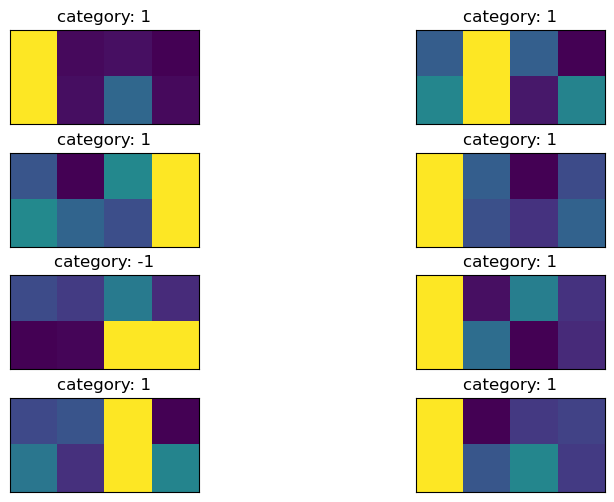

In [20]:
import matplotlib.pyplot as plt
 
# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)
 
# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
 
for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

Each subplot shows a small image, either with a **horizontal** or **vertical** bright stripe,  
corresponding to its label in `train_labels`.


In [21]:
print(train_labels[:8])

[1, 1, 1, 1, -1, 1, 1, 1]


# Variational Quantum Classifier: A First Attempt

In this section, we begin constructing a **variational quantum classifier (VQC)** to perform binary classification on our dataset of horizontal and vertical line images.  

The main goal is to build a function  

$$
f_\theta(\vec{x}) = \langle 0 | U^\dagger(\vec{x}) W^\dagger(\theta) O W(\theta) U(\vec{x}) | 0 \rangle
$$  

where:  
- $U(\vec{x})$: **encoding circuit** that loads classical data.  
- $W(\theta)$: **variational circuit (ansatz)** containing trainable parameters.  
- $O$: **observable** measured to estimate outcomes.  

The parameters $\theta$ will be optimized by a classical algorithm to minimize the loss between predictions and true labels.


In [22]:
from qiskit.circuit.library import z_feature_map
 
# One qubit per data feature
num_qubits = len(train_images[0])
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")


## Designing the Ansatz

The ansatz (trainable part of the circuit) determines how flexible the model is.  
When designing an ansatz, several factors should be considered:

- **Hardware constraints:** Deep circuits suffer from noise and decoherence.  
- **Problem structure:** Entanglement between adjacent pixels can capture spatial correlations.  
- **Number of parameters:** More parameters increase expressibility but can cause *barren plateaus* (flat optimization landscapes).

Below, we define a simple two-layer variational ansatz using rotation and CNOT gates.


5
2+ qubit depth: 3


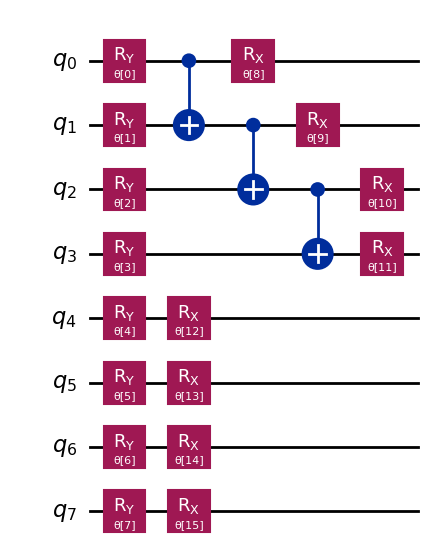

In [23]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
 
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")


This ansatz consists of two rotation layers and a few CNOT gates connecting adjacent qubits.  
The circuit depth and entanglement pattern can be adjusted later for performance tuning.

Now, we combine the **feature map** (data encoding) with the **ansatz** to form the full quantum model.


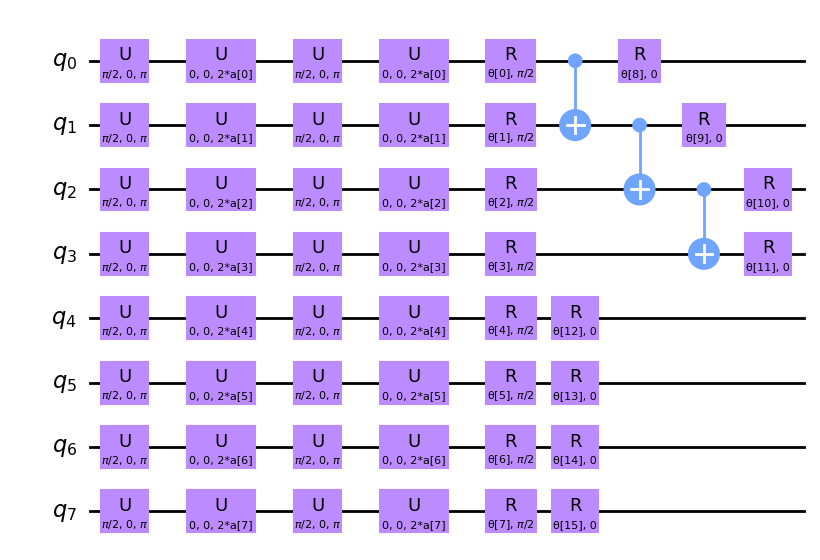

In [24]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)


The resulting circuit resembles a **quantum neural network (QNN)**:  
- The **feature map** acts like an *input layer*.  
- The **ansatz** functions like a *hidden layer with trainable weights*.  

Although this analogy is useful, we should remember that VQCs need not follow neural network architectures strictly.


In [25]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

## Defining the Observable

We now define the observable $O$ to measure the circuit output.  
Since this is a binary classification problem, measuring in the **Pauli-Z basis** is natural because:

- $Z$ has eigenvalues **±1**, matching our label set.  
- It’s easy to measure without adding extra gates.  
- The resulting expectation values lie in **[-1, 1]**, with 0 as a natural decision boundary.


In [26]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit import QuantumCircuit as _QC  # to help type hints in some editors
import numpy as _np  # avoid accidental shadowing
 
def forward(
    circuit: _QC,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

## Loss Function

To train the VQC, we define a **mean squared error (MSE)** loss between the model predictions and true labels.  
This measures how close the circuit’s expected output is to the target label.


In [27]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")


The next loss function version is designed for the optimizer:  
it depends **only** on the variational parameters $\theta$, since input data and labels are treated as fixed global variables during optimization.


In [28]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost


## Classical Optimization

We will minimize the loss function using a **classical optimizer**.  
In this example, we choose **COBYLA**, which is well-suited for noisy or gradient-free optimization.


In [29]:
from scipy.optimize import minimize

Finally, we define some **global variables** used in the optimization process.  
These include the circuit, observable, and containers to store loss values during training.


In [30]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

At this point, we have all the components of a **basic variational quantum classifier**:
1. A **data encoding** circuit (`feature_map`),
2. A **trainable ansatz**,
3. An **observable** to measure,
4. A **loss function**, and
5. A **classical optimizer** to tune parameters.

In the next step, we’ll combine these to train and test the model on our dataset.


# Qiskit Patterns Step 2: Optimize Problem for Quantum Execution

In this step, we prepare our **variational quantum classifier (VQC)** for execution on a **quantum backend**.  
If you have access to an IBM Quantum account, you could select a real hardware device (for example, `ibm_brisbane`).  
However, in this notebook we will use the **Aer simulator**, which allows running the same transpilation and optimization flow locally.

We will:
1. Select the **Aer simulator backend**.
2. Optimize the circuit using Qiskit’s transpiler with `optimization_level=3`.
3. (Optional) On real hardware, one could add **dynamical decoupling** and scheduling for pulse-level optimization —  
   but these steps are skipped here, since Aer does not include timing information.


In [37]:
# Use Aer simulator only (no scheduling / DD)
from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Select Aer simulator backend
backend = Aer.get_backend("aer_simulator")

# Build a preset pass manager from Aer's target (no scheduling passes)
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)


## Circuit Optimization for Simulation

Our circuit is optimized for execution on the **Aer simulator**, not real quantum hardware.  
This means the transpiler focuses on gate simplification and layout optimization,  
but skips time-dependent passes such as scheduling and dynamical decoupling.

The `optimization_level=3` preset still performs advanced optimizations like:
- Gate cancellation and commutation simplification  
- Efficient qubit layout mapping  
- Two-qubit gate depth reduction  

In [38]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

After optimization, we apply the resulting **qubit layout** to both the circuit and the observable  
to ensure consistency between the logical and physical qubits.

This makes the circuit ready for efficient simulation —  
and the same workflow could later be extended to real IBM Quantum hardware with pulse-level passes.

# Qiskit Patterns Step 3: Execute Using Qiskit Primitives

In this step, we **train our variational quantum classifier (VQC)** using Qiskit’s **Estimator primitive**.  
We begin with a simulator-based run to verify that our circuit, loss function, and optimizer are working correctly.  
Once validated, the same workflow can be applied to real hardware by replacing the Estimator with a hardware backend.

We will:
1. Define training hyperparameters such as batch size and number of epochs.  
2. Initialize random weights for the variational circuit.  
3. Loop through the dataset in batches to train the model using the **COBYLA** optimizer.


In [39]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]


Epoch: 0, batch: 0
Iter: 0, loss: 1.0002309063537163
Iter: 50, loss: 0.9434121445009261


## Training the Variational Quantum Classifier

The **Estimator primitive** computes the expected value of the observable for each batch,  
which represents the model’s prediction for the input data.

- `batch_size` controls how many samples are processed per optimizer update.  
- `num_epochs` defines how many times the full dataset is cycled through during training.  
- The **COBYLA** optimizer updates the circuit parameters to minimize the mean squared error (MSE) loss.  

The printed log shows the epoch, batch number, and current loss values during optimization.  
This helps confirm that the training loop and optimizer are functioning as expected.


Once convergence is observed, the optimized parameters `weight_params` can be used for evaluation  
or transferred to a hardware backend for execution.


# Qiskit Patterns Step 4: Post-process & Evaluate

Now we interpret the training result in **classical format**.  
We first evaluate **training accuracy**, then check **test accuracy**, and finally diagnose why performance may be poor by:
- Inspecting the **loss trajectory** for convergence,
- Visualizing **misclassified samples** to spot systematic errors (e.g., vertical lines being missed).

This step confirms whether the current ansatz, optimization steps, and data mapping are adequate.


In [40]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")


[-2.27688499e-02 -1.46227204e-02 -1.73927452e-02  9.93331786e-02
 -4.85553548e-01  1.43558565e-01  8.34567054e-02 -1.40133992e-02
  1.52169596e-01 -1.95082515e-01  8.24373578e-03 -9.90696638e-02
 -3.54268344e-02 -4.77017954e-01  1.38713848e-02 -2.99706215e-01
 -5.78378029e-02  3.25528779e-02 -4.11354239e-02 -1.06483708e-01
  1.53095800e-01  2.90110884e-02  1.25745450e-02  6.46323079e-02
 -1.53538943e-01 -1.57694952e-02 -1.67800067e-02 -1.99820822e-01
  1.70360075e-01  7.86148038e-03 -2.33373818e-02  6.64233020e-02
 -1.14895445e-01 -1.11296215e-01  1.15120303e-01 -2.94096140e-01
 -1.00531392e-03 -1.69209726e-01 -1.26120885e-01  3.26298176e-02
 -1.33517383e-02 -5.86983444e-02 -4.32341361e-01 -4.36509551e-01
 -4.17940102e-02  1.76935235e-03  8.14479984e-03  1.86985655e-01
 -2.75525019e-01 -1.63229907e-03 -1.08571055e-01 -7.37452386e-04
 -6.44440657e-02  6.72812834e-04  2.16785530e-03  1.41381850e-01
 -9.82570410e-02  4.35973325e-01 -7.62261965e-02 -1.86193980e-01
 -1.56971183e-02 -4.02757

## Evaluate on the Test Set

Training accuracy alone can be misleading; we must evaluate **generalization** on unseen data.  
Below we compute predictions on the **test** split, convert them to labels, and measure accuracy.


In [41]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-2.77978120e-01 -2.62194862e-01  4.59636095e-02 -8.09344165e-02
 -2.97362966e-01  9.22947242e-02  2.06693174e-01  3.31629460e-02
  1.10971762e-03 -2.14602152e-01 -1.62671993e-01 -6.07179155e-04
 -1.59948633e-01 -8.55722523e-02 -1.13057027e-01 -3.00187433e-01
 -2.92832827e-01  7.38580629e-02 -6.03706270e-02 -8.57643552e-02
 -1.52402062e-02 -3.57505447e-01 -3.54890597e-02  1.36534749e-01
 -1.54688180e-01 -2.93714726e-01  1.89548513e-02 -6.15715564e-02
  1.11042670e-01 -2.22861100e-02 -3.84230105e-02  1.67351034e-01
 -8.38766333e-02  2.56348613e-01 -1.10653111e-01 -1.18989476e-01
 -6.75723266e-05 -6.88580547e-02  1.02431393e-02 -2.42125353e-01
 -1.09142367e-01 -1.22540757e-01 -1.63735850e-01  3.93334838e-01
  2.36705685e-01 -2.34259814e-02 -3.91877756e-02 -1.95106746e-01
  1.86707523e-01  4.74775215e-02 -4.24907432e-02 -2.06453265e-01
  4.09184710e-02 -3.54762080e-02 -9.47513112e-02  2.97270112e-01
 -2.99708696e-02  9.93941064e-03 -1.26760302e-01 -1.36183355e-01]
[-1. -1.  1. -1. -1.  1.

## Diagnose: Convergence and Model Bias

With **~60%** accuracy, we should check whether:
1) The optimizer needed **more iterations** (local minima vs. early stopping),  
2) The **ansatz** misses task-relevant correlations (e.g., vertical adjacency),  
3) The **parameter count**/depth makes training hard (barren plateaus, noisy gradients).

We start by inspecting the **loss curve** collected during training to see if it plateaued.


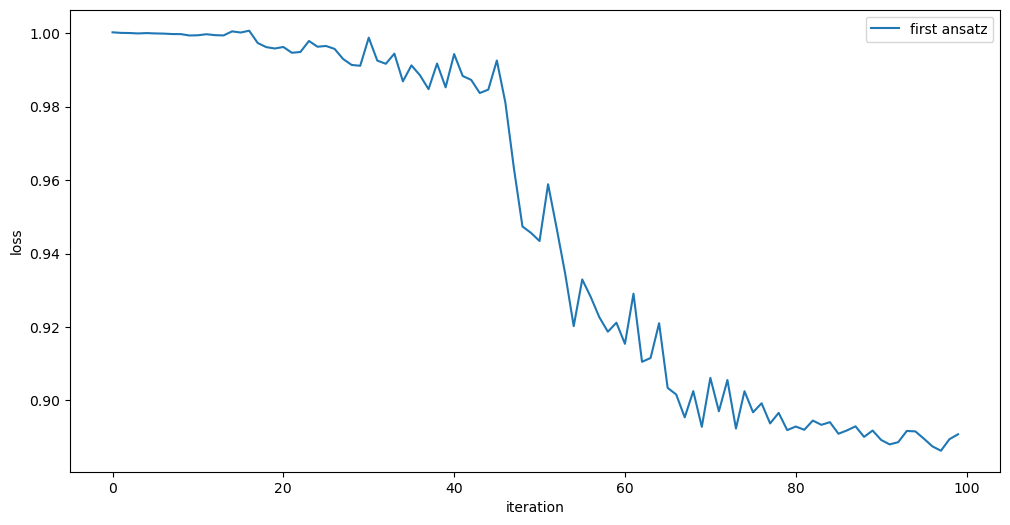

In [42]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

If the loss has already flattened, simply extending iterations may not help.  
Next, we examine **misclassified** test samples to detect systematic failure modes (e.g., vertical lines).


In [43]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_images[i])
print(len(missed))

24


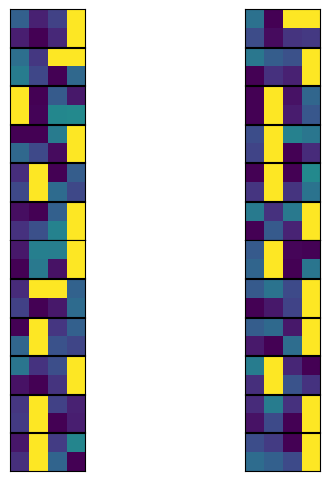

In [44]:
fig, ax = plt.subplots(12, 2, figsize=(6, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(len(missed)):
    ax[i // 2, i % 2].imshow(
        missed[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.02, hspace=0.025)

### Interpretation

If most errors are **vertical-line** images, the current entanglement pattern likely **captures horizontal adjacency** better than vertical.  
This suggests a **model-structure issue**, not only an optimization issue. In later steps, we will modify the ansatz to align entangling CNOTs with the **pixel adjacency** relevant to the class boundary.


# Improving the Model — Step 1 Revisited

To improve classification, we align the variational circuit’s entanglement pattern with the **adjacency structure** of pixels.  
The first attempt emphasized CNOTs across the top row only, which biased the model toward **horizontal** adjacency at the top and ignored the lower row.

Here we extend the CNOT list to cover **all horizontally adjacent pairs** across both rows: `[0,1]`, `[1,2]`, `[2,3]`, and `[4,5]`, `[5,6]`, `[6,7]`.  
This keeps circuit depth unchanged but should capture the correlations that identify a **horizontal line anywhere** in the image.  
(Vertical CNOTs could be considered later, but we first test whether robust horizontal detection suffices.)


5
2+ qubit depth: 3


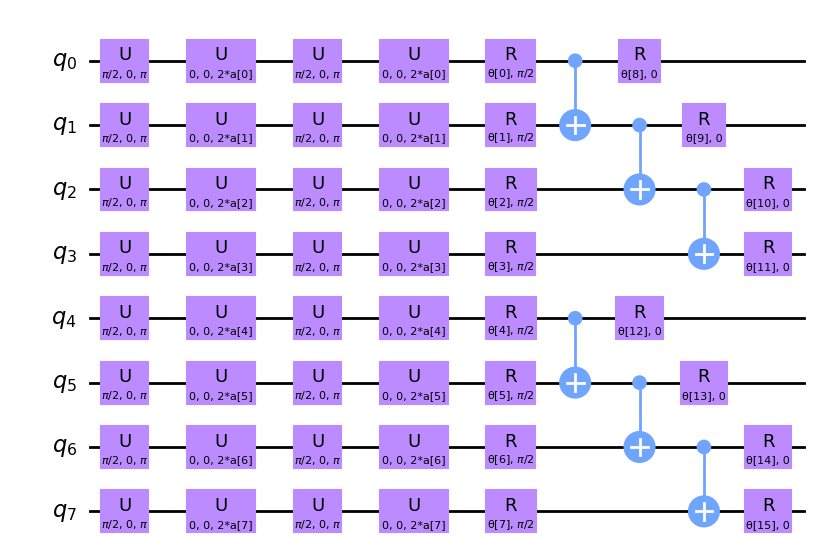

In [45]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [6, 7]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Combine the feature map and variational circuit
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

The depth remains unchanged, so any accuracy gains are due to **better inductive bias** rather than larger capacity.  
Next, we re-run training on the simulator to see the impact of this revised entanglement pattern.


# Step 2 Revisited — Transpilation for Hardware

In a realistic workflow, we would next **transpile** this revised circuit for a real quantum backend  
to map its gates to the hardware topology and align pulses for minimal idle time.

For now, we **skip transpilation** to focus purely on whether the new variational circuit structure  
improves performance on simulators. We will revisit backend-specific optimization later.


# Step 3 Revisited — Training the Updated Model

We now train the improved model using the same dataset and optimization setup as before.  
The goal is to see if this revised entanglement layout enables faster convergence and higher accuracy.

Training again uses the **StatevectorEstimator** (simulator) and the **COBYLA** optimizer.  
The optimization loop structure and hyperparameters remain unchanged.


In [46]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0049762969140237
Iter: 50, loss: 0.8274276543780358


# Step 4 Revisited — Convergence & Accuracy

We first look at the **loss trajectory** to check whether optimization has converged.  
Although complete convergence isn’t strictly necessary for this exploration, a trending decrease indicates the revised ansatz is easier to train.


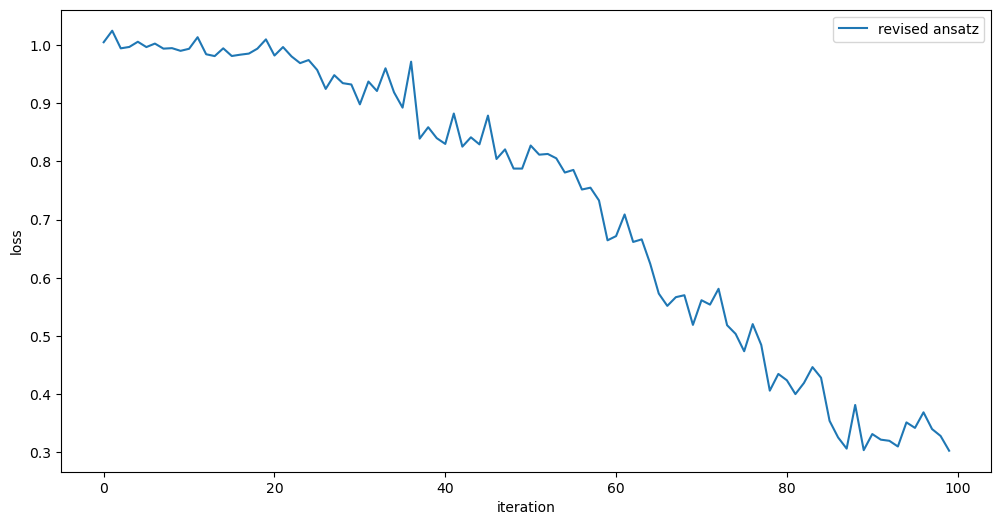

In [47]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

Even without full convergence, the loss is already **substantially lower** than the first attempt, suggesting the new entanglement pattern better matches the data structure.  
Now we evaluate **training** and **test** accuracy.


In [48]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.46144755  0.42579688  0.35255977  0.55207273 -0.48578418  0.50805845
  0.44892649  0.6173847  -0.62428139  0.40405121  0.46862421  0.29503395
 -0.5740469  -0.71794562 -0.45022095 -0.45330418 -0.19795258 -0.46821777
 -0.5622049  -0.32114059  0.54947838 -0.4889812   0.28327445  0.58149728
 -0.27026749  0.41328304  0.21119412  0.60108606  0.39204178 -0.24974605
  0.38496469  0.39867586 -0.38946996  0.62616766  0.61212525 -0.49719567
  0.30860002  0.68443904 -0.27505907 -0.41508947 -0.49666422  0.67716994
 -0.54696613 -0.70058779  0.42711815 -0.5285338   0.37678572  0.43888249
 -0.30844464  0.42347715 -0.4250844   0.67324132  0.59914067 -0.45184567
  0.13604098  0.65336342  0.26099853  0.60316559 -0.38743183 -0.54784284
 -0.29549031 -0.45592302  0.41613453 -0.38781528  0.56903087  0.54955451
  0.55532336 -0.3931852  -0.57599675  0.61246236  0.42014135 -0.38171749
  0.56760389  0.45383135 -0.50473943 -0.47551181  0.54221517 -0.64987023
  0.28845851  0.54403865  0.53841148  0.64477078  0

With the revised ansatz, the model achieves **perfect training accuracy** on this toy dataset.  
Next, we verify **generalization** on the test set.


In [49]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-0.48396136 -0.57123828  0.28373249  0.38983869 -0.45799092 -0.63643031
  0.69164877 -0.47749808  0.16965244 -0.39669469  0.39366915  0.44206948
  0.69733951  0.40445979 -0.33663432  0.54511581 -0.49397081  0.55934553
  0.69269512  0.38875983  0.39724004 -0.49635863 -0.19131387  0.38813936
  0.39537369 -0.46262489  0.5307315   0.21783317  0.31949453 -0.49772087
  0.56409526 -0.66254365 -0.57507262  0.37363552  0.35154205  0.69295687
 -0.31205475  0.37787066  0.67903997 -0.29984861 -0.46435535 -0.32610974
  0.4327188   0.64626537  0.37592731 -0.14328906  0.59694745  0.71880638
  0.32414334  0.42119333 -0.60745236 -0.42520033  0.28334222  0.21699081
  0.34837252  0.31538989  0.30754545  0.5995197  -0.34678026 -0.46587602]
[-1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.
  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1.  1.  1. -1. -1.]
[-1, -1, 1, 1, -1, -1, 1

## Interpretation

The revised entanglement layout captures the **row-wise adjacency** signal that distinguishes horizontal vs. vertical stripes, yielding **100% accuracy** on both train and test for this simplified dataset.

Key takeaway: incorporating **problem structure** (adjacent-pixel correlation) into the ansatz can matter more than simply increasing depth or parameters.  
In practice, similar reasoning guides choices such as where to place entanglers, whether to include vertical CNOTs, and how to balance expressivity with trainability.


# Scaling and Running on Real Quantum Computers (Summary Overview)

This document provides a conceptual summary of how a quantum image classification experiment can be scaled and executed on real IBM Quantum hardware. The example uses a $6 \times 6$ grid image (36 pixels) where each pixel corresponds to one qubit, resulting in a total of 36 qubits per image. Each image contains either a horizontal or vertical bright line, encoded using rotation angles where $\pi/2$ marks the bright pixels and random noise between $0$ and $\pi/4$ represents background values. Labels are assigned as $-1$ for horizontal lines and $+1$ for vertical lines. The dataset is intentionally small, containing around ten samples, to illustrate the workflow while keeping computational requirements manageable.

Each image is reshaped into a $6 \times 6$ matrix to visualize its structure and confirm the presence of the target patterns. The quantum circuit is constructed using two key components: a **feature map** (`z_feature_map`) that encodes classical pixel values into quantum rotations, and a **variational ansatz** that applies parameterized $R_Y$ and $R_X$ gates along with CNOT entanglement between adjacent qubits. The full model circuit is expressed as the composition of the feature map and the ansatz, maintaining a relatively shallow logical depth of about 11 before transpilation.

The measurement operator used for this model is a global Pauli-Z observable, defined as  
$O = Z_0 Z_1 Z_2 \dots Z_{35}$,  
which measures the overall polarization of the quantum state. This observable provides the scalar output used in the loss function for training. Before running on a real device, the circuit undergoes transpilation — an optimization process that maps the logical qubits to physical qubits according to the backend’s topology. The optimization is performed at level 3, including scheduling and dynamical decoupling passes. After transpilation, the total circuit depth increases to roughly 80, with a two-qubit depth around 10, which is acceptable for mid-sized hardware such as `ibm_brisbane`.

In a real quantum execution scenario, the Qiskit Runtime `EstimatorV2` would be used to calculate expectation values efficiently. The workflow involves initializing a session with the backend, encoding image data as circuit parameters, computing the expectation values of the observable, and iteratively updating circuit parameters using a classical optimizer such as COBYLA. However, in this environment, hardware execution is not possible, so these steps are described only conceptually.

The optimization process in practice would show slow convergence, as the small dataset and limited iterations result in nearly flat loss curves. The parameter count (72 trainable parameters) can be reduced by grouping or tying qubit rotations to improve efficiency. Empirically, noise and queue times on real hardware would also limit accuracy. Still, this setup effectively demonstrates how a hybrid quantum-classical model can be implemented and scaled for physical devices.

Overall, this workflow highlights the importance of circuit depth reduction, efficient transpilation, and parameter management when scaling to real quantum computers. The described procedure serves as a structured blueprint for educational and experimental purposes, guiding future implementation on actual IBM Quantum hardware.


## Closing

To recap, in this lesson we learned the workflow for binary classification of images using a quantum neural network. Some key considerations in each Qiskit patterns step were:

**Step 1: Map the problem to a quantum circuit**
- Load training data (e.g., with `z_feature_map`).
- Construct an ansatz with rotation and entanglement layers appropriate for the problem.
- Monitor circuit depth.

**Step 2: Optimize problem for quantum execution**
- Select a backend (often least busy).
- Use a pass manager to transpile both circuit and observables.
- For large circuits, transpile multiple times and choose the shallowest result.

**Step 3: Execute using Qiskit (Runtime) Primitives**
- Debug on simulators first.
- Execute on IBM® quantum computers.

**Step 4: Post-process**
- Compute accuracy on train/test.
- Monitor optimization convergence.


## Wrap-up — Quick Self-Check

<details>
<summary>1. What is the primary purpose of using a <b>parameterized quantum circuit (PQC)</b> in variational quantum algorithms?</summary>

A. To measure classical data directly without encoding  
B. To introduce tunable parameters that can be optimized for a cost function 
C. To replace observables with fixed values  
D. To avoid using any classical optimization loop
</details>

---

<details>
<summary>2. Why do we use an <b>Estimator primitive</b> instead of manually sampling measurement outcomes?</summary>

A. It generates random samples faster  
B. It directly computes expectation values of observables 
C. It replaces the need for quantum circuits  
D. It automatically optimizes circuit parameters
</details>

---

<details>
<summary>3. How does using a <b>matrix product state (MPS)</b> simulator help in scaling up to 36 qubits?</summary>

A. It increases the number of physical qubits available  
B. It ignores entanglement entirely  
C. It compresses the quantum state to handle limited entanglement efficiently  
D. It reduces the accuracy of the simulation intentionally
</details>

---

<details>
<summary>4. In a VQC, what is the role of the <b>observable</b> (e.g., Pauli Z operators) during training?</summary>

A. It defines which qubits to ignore  
B. It specifies what quantity the circuit measures and optimizes against  
C. It provides random initialization angles  
D. It limits the number of entangling gates
</details>

---

<details>
<summary>5. Why might <b>COBYLA</b> be preferred over gradient-based optimizers for certain quantum models?</summary>

A. It runs faster on GPUs  
B. It does not require gradient information and handles noisy objectives well 
C. It always converges to the global minimum  
D. It minimizes circuit depth automatically
</details>

---

<details>
<summary>6. What is the trade-off between <b>shots</b> and <b>training stability</b> in quantum optimization?</summary>

A. Fewer shots improve accuracy but increase runtime  
B. More shots reduce runtime but increase variance  
C. Fewer shots increase noise but run faster, while more shots give smoother results 
D. Shots have no effect on optimization performance
</details>

---

<details>
<summary>7. How does the <b>depth</b> of a variational circuit affect trainability and noise sensitivity?</summary>

A. Deeper circuits are always better for all problems  
B. Shallow circuits can’t represent correlations  
C. Deeper circuits capture more correlations but are harder to train and noisier 
D. Circuit depth affects only hardware speed, not trainability
</details>

---

<details>
<summary>8. Why is <b>simulator–hardware compatibility</b> an important consideration in VQC design?</summary>

A. Simulators always perform worse than hardware  
B. Some circuits efficient in simulation may be too deep or use unsupported gates on real devices 
C. Hardware automatically optimizes circuits to match simulators  
D. Compatibility has no effect on experiment outcomes
</details>
